# Анализ данных в задаче кредитного скоринга

Для выполнения задания используются данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

* `LIMIT_BAL`: размер кредитного лимита (в том числе и на семью клиента)
* `SEX`: пол клиента (1 = мужской, 2 = женский )
* `EDUCATION`: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* `MARRIAGE`: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* `AGE`: возраст в годах
* `PAY_0 - PAY_6` : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* `BILL_AMT1 - BILL_AMT6`: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* `PAY_AMT1 - PAY_AMT6`: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* `default` - индикатор невозврата денежных средств

## Импорт данных

In [181]:
# Import needed packages
import pandas as pd
import numpy as np

import seaborn as sns

from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportion_confint

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [21]:
data = pd.read_csv("credit_card_default_analysis.csv", index_col='ID')
data.shape

(30000, 24)

In [22]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [13]:
data.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

## Задача 1

Размер кредитного лимита (`LIMIT_BAL`). В двух группах, тех людей, кто вернул кредит (`default = 0`) и тех, кто его не вернул (`default = 1`)<br>
Проверим гипотезы:<br>
a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки <br>
b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.<br>
Значимы ли полученные результаты с практической точки зрения?

In [84]:
data.groupby('default')['LIMIT_BAL'].mean().round(2)

default
0    178099.73
1    130109.66
Name: LIMIT_BAL, dtype: float64

In [83]:
data.groupby('default')['LIMIT_BAL'].median()

default
0    150000
1     90000
Name: LIMIT_BAL, dtype: int64

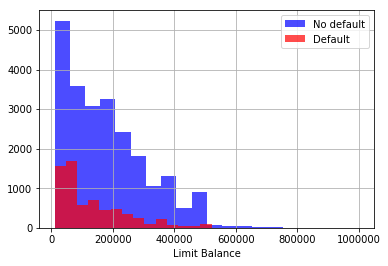

In [59]:
data['LIMIT_BAL'][data.default == 0].hist(
    color='blue', alpha=0.7, bins=20, label='No default')
data['LIMIT_BAL'][data.default == 1].hist(
    color='red', alpha=0.7, bins=20, label='Default')
plt.legend();
plt.xlabel('Limit Balance');

#### Интервальная оценка разности медиан с помощью Bootstrap

In [42]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    boundaries = np.percentile(
        stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [43]:
no_default_limit = data['LIMIT_BAL'][data.default == 0].values
default_limit = data['LIMIT_BAL'][data.default == 1].values

In [52]:
np.random.seed(0)

no_default_med_scores = list(
    map(np.median, get_bootstrap_samples(no_default_limit, 1000)))
default_med_scores = list(
    map(np.median, get_bootstrap_samples(default_limit, 1000)))

print("95% confidence interval for the median limit balance of non-defaulters:",
      stat_intervals(no_default_med_scores, 0.05))
print("95% confidence interval for the median limit balance of defaulters:",
      stat_intervals(default_med_scores, 0.05))

95% confidence interval for the median limit balance of non-defaulters: [150000. 150000.]
95% confidence interval for the median limit balance of defaulters: [80000. 90000.]


Доверительные интервалы не пересекаются, следовательно, медианы размеров кредитного лимита для возвратных и невозвратных кредитов неравны.

In [51]:
delta_median_scores = list(
    map(lambda x: x[1] - x[0], 
        zip(no_default_med_scores, default_med_scores)))

print("95% confidence interval for the difference between medians",
      stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [-70000. -60000.]


**Вывод**: медианные значения кредитных лимитов клиентов вернувших и не вернувших денежные средства отличается.

#### Проверка равенства распределений с помощью непараметрических критериев проверки равенства средних

Воспользуемя критерием Манна-Уитни.

$H_0$ - средние двух выборок равны.<br>
$H_1$ - средние двух выборок отличаются.

In [81]:
stats.mannwhitneyu(no_default_limit, default_limit, alternative='two-sided')

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)

Нулевая гипотеза отвергается на уровне значимости 0.05. 

**Вывод**: мы можем отвергнуть  гипотезу о равенстве среднего кредитного лимита у двух типов заемщиков.

Полученные результаты сами по себе не значимы с практической точки зрения, но могут быть использованы в дальнейшем анализе и вместе с другими критериями.

## Задача 2

Пол (`SEX`): Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Предоставим несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия).

Посмотрим, сколько женщин и мужчин в нашем датасете:

In [63]:
data.SEX.value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

Посмотрим на процент невернувших денежные средства для разных гендерных групп:

In [70]:
pd.crosstab(data.SEX, data.default, normalize='index', margins=True).round(2)

default,0,1
SEX,,
1,0.76,0.24
2,0.79,0.21
All,0.78,0.22


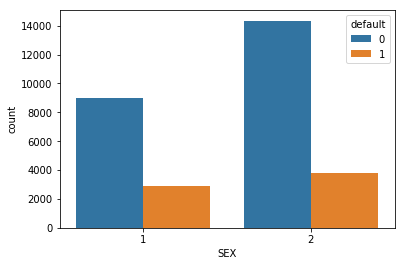

In [80]:
sns.countplot(data.SEX, hue=data.default);

Видим, что процент женщин не вернувших денежные средства меньше, чем аналогичный процент мужчин. 

In [88]:
no_default = data[data.default == 0]
default = data[data.default == 1]

#### Интервальные оценки доли мужчин в двух выборках: default, non-default

In [94]:
proportion_no_default = proportion_confint(
    sum(no_default.SEX == 1), len(no_default), alpha=0.05, method='wilson')
proportion_default = proportion_confint(
    sum(default.SEX == 1), len(default), alpha=0.05, method='wilson')

In [128]:
print('interval for percent of males in non-default: [{:.4f}, {:.4f}]'.format(
    *proportion_no_default))
print('interval for percent of males in default: [{:.4f}, {:.4f}]'.format(
    *proportion_default))

interval for percent of males in non-default: [0.3796, 0.3921]
interval for percent of males in default: [0.4211, 0.4449]


Теперь посчитаем доверительный интервал для разности долей (независимые выборки)

In [136]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [140]:
print("95% confidence interval for a difference in proportions: [{:.4f}, {:.4f}]".format(*proportions_diff_confint_ind(
    no_default.SEX == 1, default.SEX == 1)))

95% confidence interval for a difference in proportions: [-0.0605, -0.0336]


#### Z-критерий для разности долей (независимые выборки)

In [132]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(samplxe1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [138]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)

    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2
    P = float(p1*n1 + p2*n2) / (n1 + n2)

    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [139]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

$H_0$ - доли мужчин в двух выборок равны.<br>
$H_1$ - доли мужчин в двух выборок отличаются.

In [142]:
print("p-value: {}".format(proportions_diff_z_test(
    proportions_diff_z_stat_ind(no_default.SEX == 1, default.SEX == 1))))

p-value: 4.472866521609831e-12


Нулевая гипотеза отвергается на уровне значимости 0.05. 

**Вывод**: Полученные результаты значимы с практической точки зрения: пол заёмщика может являтся сильным индикатором невозврата кредита.

## Задача 3

Образование (`EDUCATION`): Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг. 

In [150]:
data.EDUCATION.value_counts().sort_index()

0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: EDUCATION, dtype: int64

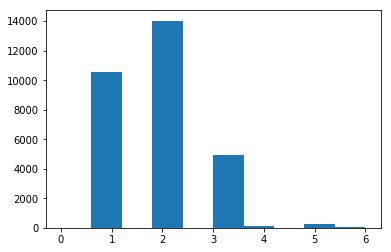

In [164]:
data.EDUCATION.hist(grid=False);

Составим таблицу сопряженности "образование" на "возврат долга", где значением ячейки будет разность между наблюдаемым и ожидаемым количеством человек.

In [301]:
education_dic = {0: 'доктор', 
                 1: 'магистр', 
                 2: 'бакалавр',
                 3: 'выпускник школы',
                 4: 'начальное образование', 
                 5: 'прочее', 
                 6: 'нет данных'}

In [302]:
pd.crosstab(data.EDUCATION, data.default,
            normalize='index', margins=True).round(2).rename(index=education_dic)

default,0,1
EDUCATION,,
доктор,1.00,0.00
магистр,0.81,0.19
бакалавр,0.76,0.24
выпускник школы,0.75,0.25
начальное образование,0.94,0.06
прочее,0.94,0.06
нет данных,0.84,0.16
All,0.78,0.22


Наибольший процент невернувших кредит серди бакалавров и выпускников школ. 

Составим таблицу с ожидаемым количеством человек в каждой группе.

In [303]:
education_crosstab = pd.crosstab(data.EDUCATION,
                                 data.default,
                                 normalize='columns',
                                 margins=True).round(4).rename(index=education_dic)

In [304]:
education_crosstab

default,0,1,All
EDUCATION,,,
доктор,0.0006,0.0000,0.0005
магистр,0.3659,0.3068,0.3528
бакалавр,0.4580,0.5018,0.4677
выпускник школы,0.1575,0.1864,0.1639
начальное образование,0.0050,0.0011,0.0041
прочее,0.0112,0.0027,0.0093
нет данных,0.0018,0.0012,0.0017


In [313]:
education_crosstab = pd.crosstab(data.EDUCATION,
                                 data.default,
                                 margins=False).round(4).rename(index=education_dic)
education_crosstab

default,0,1
EDUCATION,,
доктор,14,0
магистр,8549,2036
бакалавр,10700,3330
выпускник школы,3680,1237
начальное образование,116,7
прочее,262,18
нет данных,43,8


Размер выборки > 40 и в каждом бине больше 5 элементов больше чем в 20% бинов. Можно использовать критерий хи-квадрат.

In [315]:
print('p-value = ', stats.chi2_contingency(education_crosstab)[1])

p-value =  1.2332626245415605e-32


## Задача 4

Семейное положение (`MARRIAGE`): Проверим, как связан семейный статус с индикатором дефолта.

In [276]:
marriage_crostab = pd.crosstab(data.MARRIAGE, data.default)
marriage_crostab 

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


In [318]:
names = ['отказываюсь отвечать', 'замужем/женат', 'холост', 'нет данных']

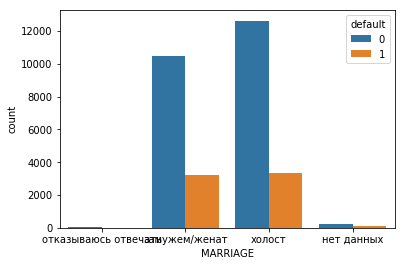

In [321]:
sns.countplot(data.MARRIAGE, hue=data.default);
plt.xticks(range(4), names);

Посчитаем уровень значимости с помощью статистики хи-квадрат

Нулевая гипотеза - частоты согласованы, то есть фактические данные не противоречат ожидаемым. Альтернативная гипотеза – отклонения в частотах выходят за рамки случайных колебаний, то есть расхождения статистически значимы. 

In [280]:
scipy.stats.chi2_contingency(marriage_crostab.values)[1]

8.825862457577375e-08

Нулевая гипотеза отвергается на уровне значимости 0.05

Определим связь через значение оэффициента V Крамера

In [316]:
def cramers_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
    """
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min( (k-1), (r-1)))

In [317]:
cramers_stat(marriage_crostab.values)

0.034478203662766466

Значение коэффициент указывает на очень слабую взаимосвязь.

## Задача 5

Возраст (`AGE`): Относительно двух групп людей вернувших и не вернувших кредит проверим следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

Мерой силы взаимосвязи между показателями возраста и возратом кредита может служить просто разность этих математи-
ческих ожиданий.

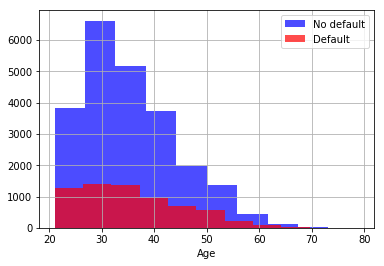

In [323]:
data['AGE'][data.default == 0].hist(
    color='blue', alpha=0.7, bins=10, label='No default')
data['AGE'][data.default == 1].hist(
    color='red', alpha=0.7, bins=10, label='Default')
plt.legend();
plt.xlabel('Age');

In [290]:
data.groupby('default')['AGE'].median()

default
0    34
1    34
Name: AGE, dtype: int64

In [291]:
no_default_age = data['AGE'][data.default == 0].values
default_age = data['AGE'][data.default == 1].values

In [292]:
np.random.seed(0)

no_default_med_scores = list(
    map(np.median, get_bootstrap_samples(no_default_age, 1000)))
default_med_scores = list(
    map(np.median, get_bootstrap_samples(default_age, 1000)))

print("95% confidence interval for the median limit balance of non-defaulters:",
      stat_intervals(no_default_med_scores, 0.05))
print("95% confidence interval for the median limit balance of defaulters:",
      stat_intervals(default_med_scores, 0.05))

95% confidence interval for the median limit balance of non-defaulters: [34. 34.]
95% confidence interval for the median limit balance of defaulters: [34. 35.]


In [293]:
delta_median_scores = list(
    map(lambda x: x[1] - x[0], 
        zip(no_default_med_scores, default_med_scores)))

print("95% confidence interval for the difference between medians",
      stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [0. 1.]


Медианы совпадают.

Воспользуемя критерием Манна-Уитни.

$H_0$ - средние двух выборок равны.<br>
$H_1$ - средние двух выборок отличаются.

In [294]:
stats.mannwhitneyu(no_default_age, default_age, alternative='two-sided')

MannwhitneyuResult(statistic=76966879.5, pvalue=0.3725035434898616)

**Вывод**: мы не можем отвергнуть нулевую гипотезу о равенстве среднего возраста у двух типов заемщиков при выбранном уровне значимости 0.05.

Полученные результаты начимы с практической точки зрения.